# Analysis of Bathymetric Data
This script was written for a different sensor that also used the Adafruit GPS Featherwing and therefore uses a very similar data format. In particular, we'll need it for parsing the GPS lat/lon data. Code chunk under "Read in data, rename columns, simple pre-processing" will have especially useful tidbits but all will need to be modified for our purposes.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.signal import butter,filtfilt

### TODO:
Don't imagine Plotly will work without significant reconfiguration. Convert to Cartopy for static maps for now.

In [2]:
# import plotly
# import plotly.graph_objs as go
mapbox_access_token = os.environ['MY_MAPBOX_KEY']

### Read in data, rename columns, simple pre-processing

In [23]:
# filename = '21052401_Baldhead_truncate_flight1.CSV'
# filename = '23071204_RipCurrent_TrailsEnd_trunc.csv'
# filename = '230719_Whiskey_Creek_Data_Oysters'

# filename = '24010401_depth-sensing-ping_CMSTest'
filename = '24031201_depth-sensing-ping_Seahawkanddock_truncate'

fullname = filename+'.csv'

filepath = os.path.join('Data', fullname)
df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None)

df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'temp (oC)', 'depth (cm)', 'altitude', 'speed', 'angle']

df.head()

,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,temp (oC),depth (cm),altitude,speed,angle
0,2024-03-12 21:12:30,92,3408.4041,N,7751.7363,W,0.68,665.24,-1.6,0.14,119.76
1,2024-03-12 21:12:31,93,3408.4041,N,7751.7363,W,0.52,220.64,-1.6,0.14,119.76
2,2024-03-12 21:12:32,94,3408.4041,N,7751.7363,W,1.08,160.52,-1.6,0.69,162.13
3,2024-03-12 21:12:33,95,3408.4038,N,7751.7363,W,2.37,23.09,-1.6,1.03,42.43
4,2024-03-12 21:12:34,96,3408.4041,N,7751.7363,W,0.27,22.79,-1.5,1.02,53.83


In [24]:
# df = df[100:-30] # TODO: replace with a filter for altitude or motion

# GPS spits out lat DDMM.MMMM, lon DDDMM.MMMM, so additional processing required
def lat_convert(lat_badfmt):
    lat_badfmt = str(lat_badfmt)
    lat_DD = int(float(lat_badfmt)/100) # get DDD part
    lat_MM = float(lat_badfmt)-lat_DD*100 # get MM.MMM part
    lat_deg = float(lat_DD)+float(lat_MM)/60 # add minutes divided by 60 to degrees
    return lat_deg

def lon_convert(lon_badfmt):
    lon_badfmt = str(lon_badfmt)
    lon_DD = int(float(lon_badfmt)/100) # get DDD part
    lon_MM = float(lon_badfmt)-lon_DD*100 # get MM.MMM part
    lon_deg = float(lon_DD)+float(lon_MM)/60 # add minutes divided by 60 to degrees
    return lon_deg

# Do the conversion on real data
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# South should be negative
south = df['N or S'] == 'S'
df['lat'][south] *= -1 

# West should be negative
west = df['E or W'] == 'W'
df['lon'][west] *= -1 

# Take a look
df.head()

/var/folders/7t/xlh_vvfj7p353njns063zqhw0000gn/T/ipykernel_29669/564657591.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'][south] *= -1
/var/folders/7t/xlh_vvfj7p353njns063zqhw0000gn/T/ipykernel_29669/564657591.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'][west] *= -1


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,temp (oC),depth (cm),altitude,speed,angle,lat,lon
0,2024-03-12 21:12:30,92,3408.4041,N,7751.7363,W,0.68,665.24,-1.6,0.14,119.76,34.140068,-77.862272
1,2024-03-12 21:12:31,93,3408.4041,N,7751.7363,W,0.52,220.64,-1.6,0.14,119.76,34.140068,-77.862272
2,2024-03-12 21:12:32,94,3408.4041,N,7751.7363,W,1.08,160.52,-1.6,0.69,162.13,34.140068,-77.862272
3,2024-03-12 21:12:33,95,3408.4038,N,7751.7363,W,2.37,23.09,-1.6,1.03,42.43,34.140063,-77.862272
4,2024-03-12 21:12:34,96,3408.4041,N,7751.7363,W,0.27,22.79,-1.5,1.02,53.83,34.140068,-77.862272


### Scale from c_air to c_water
Firmware currently calculates distance using speed of sound in air. We want speed of sound in water.

In [25]:
df['depth (cm)'] = df['depth (cm)']*1502/343

### Plot time-series

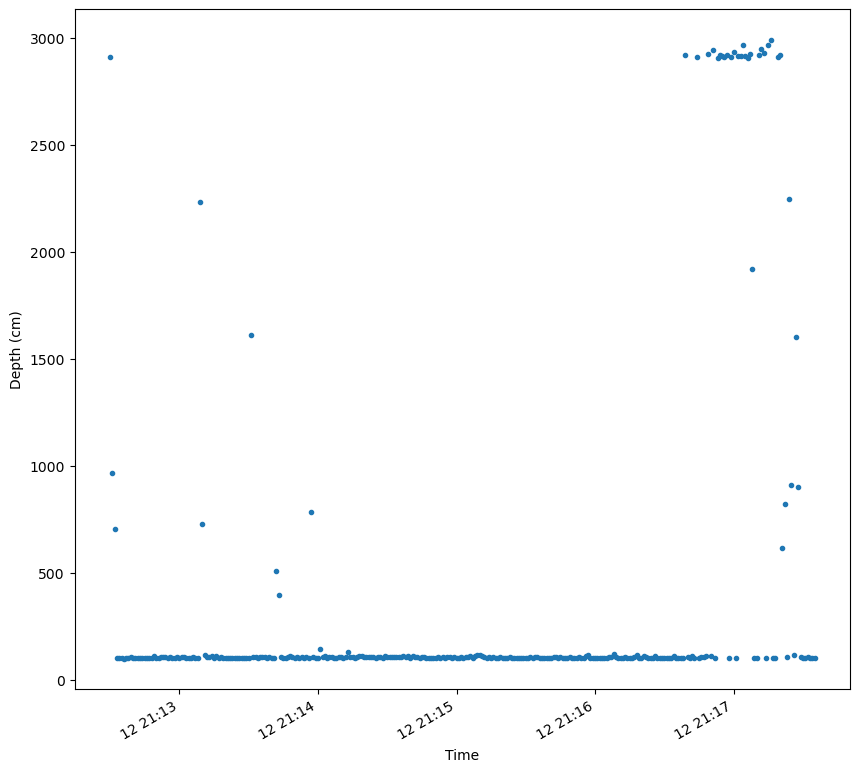

In [15]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['depth (cm)'], '.')

axs.set_ylabel('Depth (cm)')
axs.set_xlabel('Time')

fig.autofmt_xdate()

### Noise reduction

In [16]:
# Filter requirements, 
# example from https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

T = 1.0         # Sample Period, sec
fs = 150.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

### Filter def

In [17]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [18]:
# Filter the data, and plot both the original and filtered signals
depth_above_range = 600
depth_below_range = 23
df = df[df['depth (cm)']<depth_above_range]
df = df[df['depth (cm)']>depth_below_range]

data = df['depth (cm)']
depth_filt = butter_lowpass_filter(data, cutoff, fs, order)
df['depth filt (cm)'] = depth_filt

### Plot filtered time-series

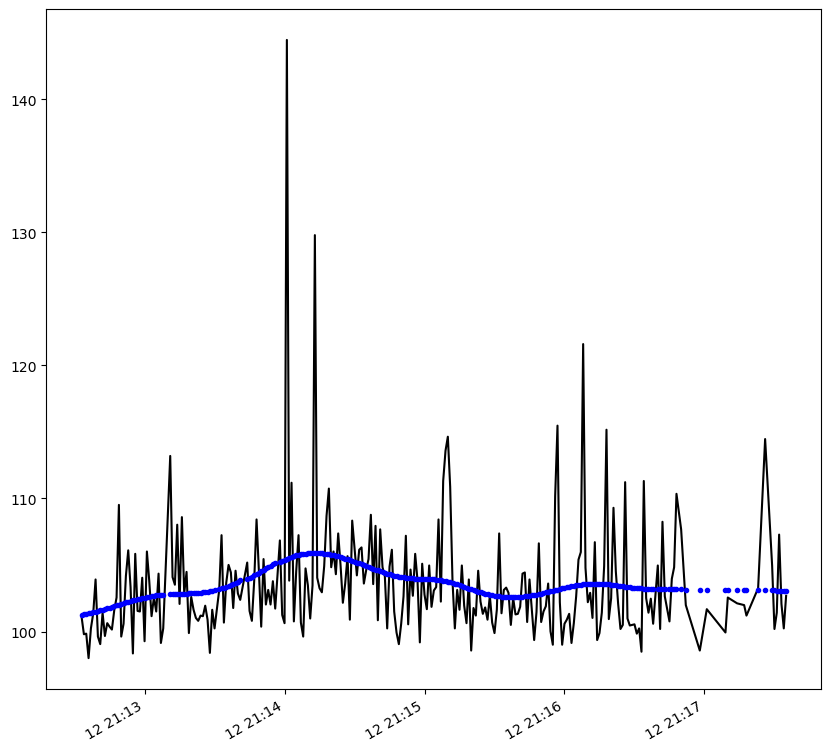

In [19]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['depth (cm)'], '-k')
axs.plot(df['time'], df['depth filt (cm)'], '.b')

fig.autofmt_xdate()

### Plot lat in order to see movement

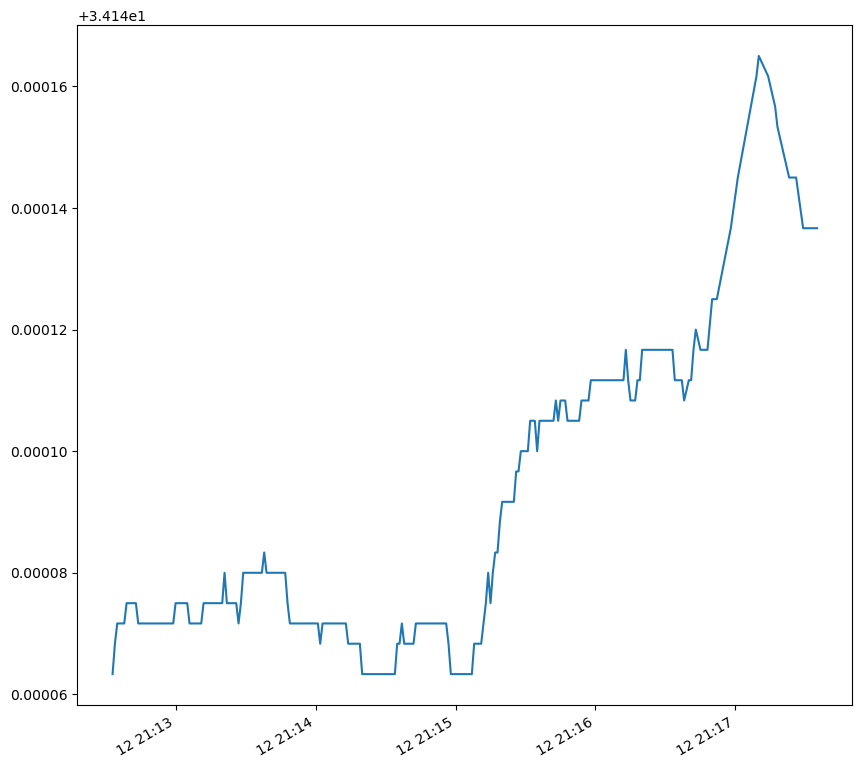

In [30]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['lat'])
fig.autofmt_xdate()

### Plot spatial data

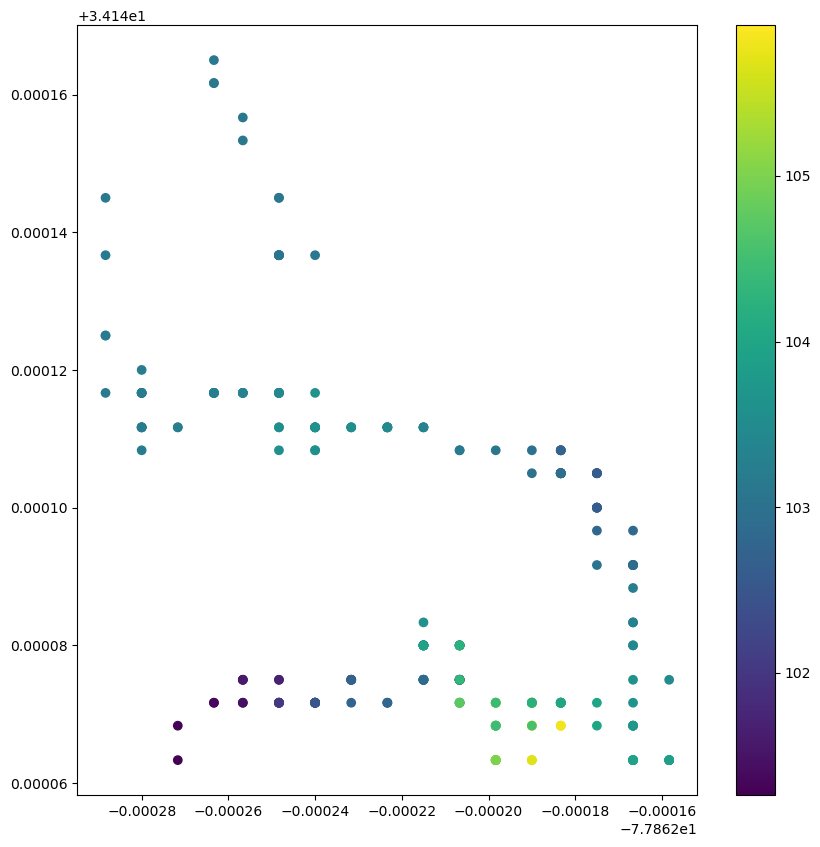

In [31]:
fig, axs = plt.subplots(figsize = (10, 10))
m = axs.scatter(df['lon'], df['lat'], c = df['depth filt (cm)'])
fig.colorbar(m)

## Map of variable of interest

### Put on cartopy to get good basemap
- Image tile options via Cartopy are currently buried in the API under cartopy.io.img_tiles described here: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. Scroll down to see different options under the different classes. Change the class 
- Here are some examples of the Mapbox style offerings: https://docs.mapbox.com/api/maps/styles/. Change `map_id` to use others.
- See also https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html for formatting.

### Options
See below for several examples. Then in subsequent cell, define which choice you'd like by setting `base_layer` and `tile_zoom` to match one of these examples.

In [42]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined
## Stamen
base_layer_stamen = cimgt.Stamen('terrain-background')
tile_zoom_stamen = 12

## Mapbox
map_id = 'satellite-streets-v11'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 20

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 15

In [43]:
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'depth (cm)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16

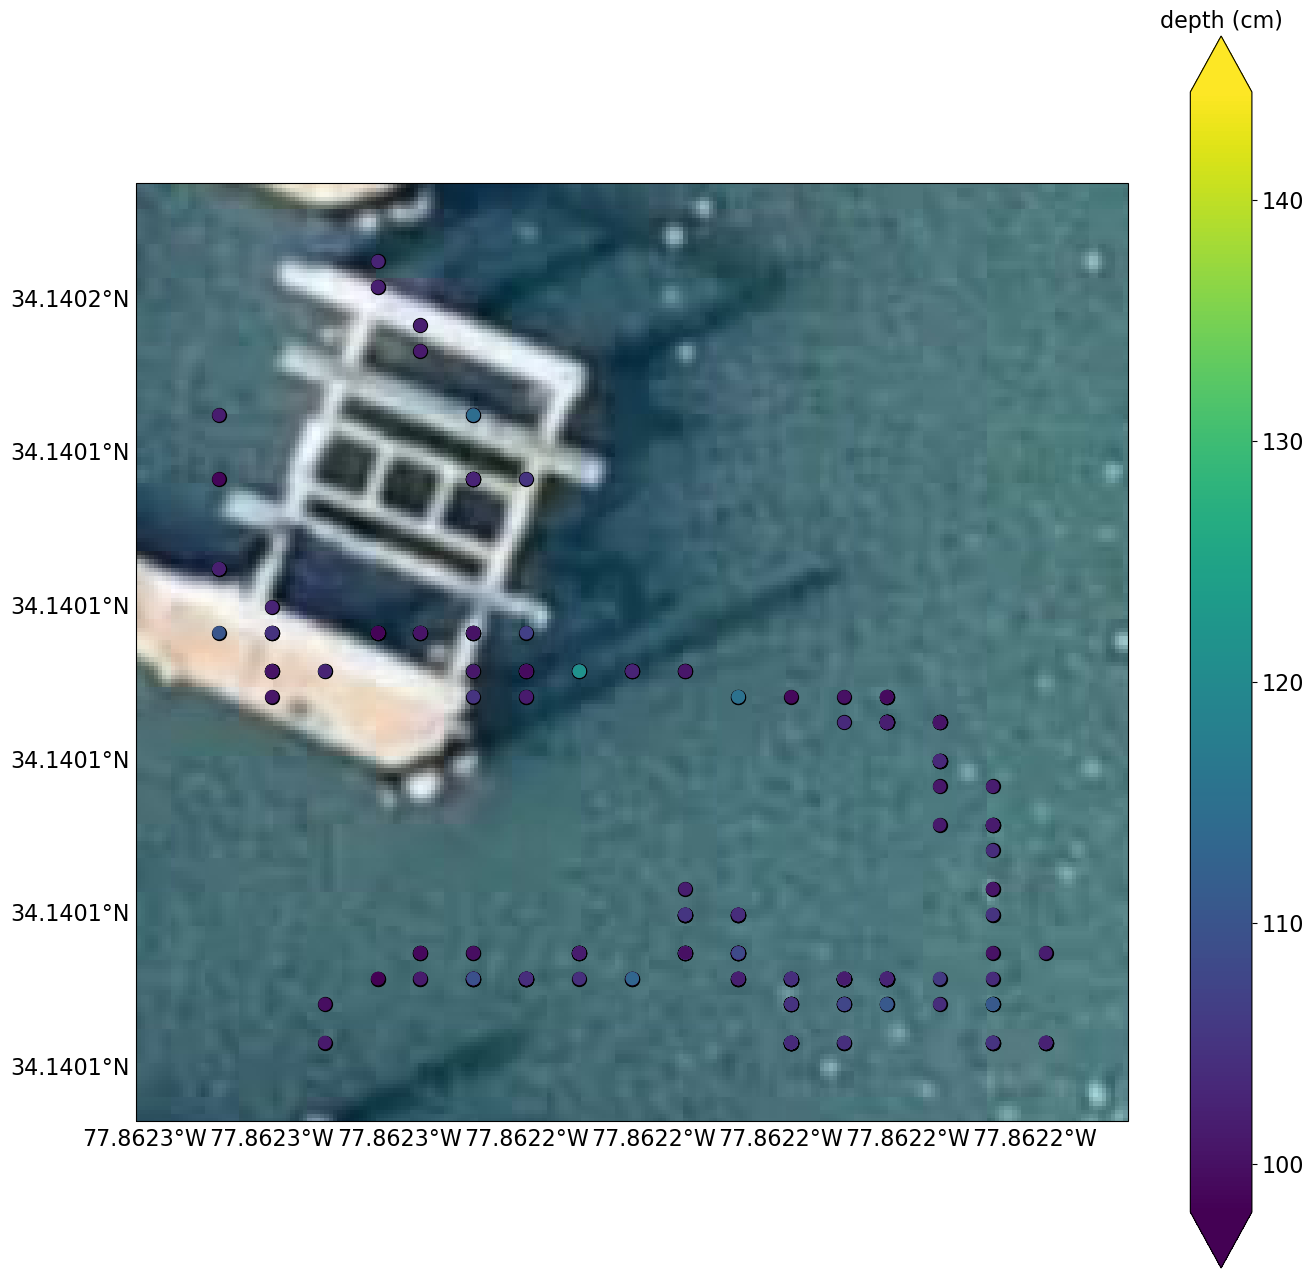

In [44]:
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)
# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally

In [45]:
df.describe()

,elapsed time (sec),lat_raw,lon_raw,temp (oC),depth (cm),altitude,speed,angle,lat,lon,depth filt (cm)
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,233.785714,3408.405321,7751.732801,3.630489,103.530138,1.622932,0.426015,168.266128,34.140089,-77.862213,103.544355
std,81.369754,0.001406,0.002059,3.759381,4.574826,1.161310,0.278741,97.328669,0.000023,0.000034,1.092794
min,95.000000,3408.403800,7751.729500,-2.630000,98.002216,-1.600000,0.010000,0.310000,34.140063,-77.862288,101.262267
25%,166.250000,3408.404300,7751.731000,0.520000,100.892362,1.100000,0.230000,100.460000,34.140072,-77.862240,102.853785
50%,233.500000,3408.404500,7751.732400,2.530000,102.512595,1.800000,0.390000,115.485000,34.140075,-77.862207,103.273188
75%,299.750000,3408.406500,7751.734400,6.640000,104.822522,2.600000,0.557500,277.890000,34.140108,-77.862183,104.030961
max,397.000000,3408.409900,7751.737300,16.710000,144.463499,3.300000,1.960000,346.460000,34.140165,-77.862158,105.910398
